In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.data import Dataset as ds

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomCrop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Load Datasets

In [2]:
# Import data into a dataframe
train= pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test= pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
print(f"Train Data Info: {train.info()}\n")
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
Train Data Info: None



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(f"Test Data Info: {test.info()}\n")
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
Test Data Info: None



,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
target= train["label"]
features= train.drop("label", axis=1)

# Split Training Dataset to Targets and Features

In [6]:
target= (train["label"].values).astype("float32")
features= (train.drop("label", axis=1).values).astype("float32")

In [7]:
print(target)
features

[1. 0. 1. ... 7. 6. 9.]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

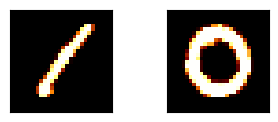

In [8]:
# plot some of the numbers
plt.figure(figsize=(8,6))
for digit_num in range(0,2):
    plt.subplot(5,5,digit_num+1)
    grid_data = features[digit_num].reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

# Preprocessing the Datasets

#### Features
Following my previous notebook I will doing the following using a function.
- **Standardize** makes the features more like standard normally distributed data: Gaussian with zero mean and unit variance
- **Scaling Data** is necessary because many machine learning algorithms (especially deep learning algorithms) expect input data in a certain shape.

In [9]:
def preprocess_data(data):

    # Initialize a new StandardScaler instance
    scaler = StandardScaler()

    # Fit the scaler to the data to standardize data
#     scaler.fit(feat_norm)
    scaler.fit(data)

    # Transform the data
#     feat_scaled = scaler.transform(feat_norm)
    feat_scaled = scaler.transform(data)
    
    # Reshape the data to 28x28 images
    feat_reshape = feat_scaled.reshape(data.shape[0], 28, 28, 1)
    
    return feat_reshape

In [10]:
feat_train= preprocess_data(features)
feat_test= preprocess_data(test)

In [11]:
print(f"Train shape: {feat_train.shape}")
print(f"Test shape: {feat_test.shape}")
print(f"Train datatype: {type(feat_train)}")
print(f"Test datatype: {type(feat_test)}")

Train shape: (42000, 28, 28, 1)
Test shape: (28000, 28, 28, 1)
Train datatype: <class 'numpy.ndarray'>
Test datatype: <class 'numpy.ndarray'>


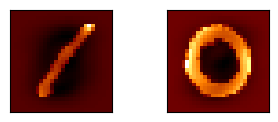

In [12]:
# visualizing some of the numbers preprocessed image
plt.figure(figsize=(8,6))
for digit_num in range(0,2):
    plt.subplot(5,5,digit_num+1)
    grid_data = feat_train[digit_num]
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [13]:
# Encoding Label data 
cat_target= to_categorical(target, )
target_classes = cat_target.shape[1]
print(cat_target)
print(f"Classes: {target_classes}")


[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Classes: 10


# Image augmentation
data augmentation methods include; randomly rotate, zoom, shift, shear, and flip images during training.

In [14]:

# img_aug= Sequential([
#     RandomFlip("horizontal"), # randomly flip image
#     RandomRotation(0.8, fill_mode='nearest'), # randomly rotate image
#     RandomZoom(0.8), # randomly zoom image
#     RandomTranslation(0.8, 0.8, fill_mode="nearest"), # randomly translate image
# ])

In [15]:
# def augment(image, label):
#     image = img_aug(image)
#     return image, label

# batch_size = 64
# AUTOTUNE = tf.data.AUTOTUNE

# def prepare(ds, shuffle=False, augment=False):
#     # shuffle add dataset
#     if shuffle:
#         ds = ds.shuffle(1000)

#     # Batch all datasets.
#     ds = ds.batch(batch_size)

#     # Use data augmentation only on the training set.
#     if augment:
#         ds = ds.map(lambda x, y: (img_aug(x, training=True), y), 
#                     num_parallel_calls=AUTOTUNE)

#     # Use buffered prefetching on all datasets.
#     return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
# using default 
gen= ImageDataGenerator()

# Test Train Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(feat_train, cat_target, test_size=0.10, random_state=42)

In [18]:
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_test, y_test, batch_size=64)

In [19]:
# Convert to TensorFlow Dataset
# train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [20]:
# Apply the augmentation
# augmented_train_ds = train_ds.map(augment)
# augmented_test_ds = test_ds.map(augment)

# augmented_train_ds= prepare(train_ds, shuffle=True, augment=True)
# augmented_test_ds= prepare(test_ds)

In [21]:
# Batch the data
# augmented_train_ds = augmented_train_ds.batch(64)
# augmented_test_ds = augmented_train_ds.batch(64)

# Build the Model

In [22]:
# Adding layers to model Keras Linear model
model = Sequential()
# model.add(img_aug) # will only apply durning model.fit, not in predict or evaluate
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(target_classes, activation='softmax')) 

In [23]:
# Compile model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# model.fit(X_train, y_train, epochs=3, batch_size=64)
# model.fit(augmented_train_ds,validation_data=augmented_test_ds , epochs=3, batch_size=64)
model.fit(batches, steps_per_epoch=batches.n, epochs=1, 
          validation_data=val_batches, validation_steps=val_batches.n)

37800/37800 [==============================] - 4s 82us/step - loss: 0.3074 - accuracy: 0.9127 - val_loss: 0.2083 - val_accuracy: 0.9390


In [25]:
# Fully connected model

def fc_model():
    model = Sequential()
#     model.add(img_aug) # will only apply durning model.fit, not in predict or evaluate
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(target_classes, activation='softmax'))
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [26]:
model = fc_model()
model.optimizer.learning_rate=0.001
# model.summary()

In [27]:
# model.fit(X_train, y_train, epochs=3, batch_size=64)
# model.fit(augmented_train_ds,validation_data=augmented_test_ds , epochs=3,)
model.fit(batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

37800/37800 [==============================] - 3s 76us/step - loss: 0.3381 - accuracy: 0.9020 - val_loss: 0.2064 - val_accuracy: 0.9402


In [28]:
# CNN
def cv_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',)),
    model.add(MaxPooling2D()),
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu')),
    model.add(MaxPooling2D()),
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')),
    model.add(MaxPooling2D()),
    model.add(Flatten()),
    model.add(Dense(128, activation='relu')),
    model.add(Dense(target_classes, activation='softmax'))
    
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [29]:
model = cv_model()
model.optimizer.learning_rate=0.01
# model.summary()

In [30]:
# model.fit(X_train, y_train, epochs=3, batch_size=64)
# model.fit(augmented_train_ds,validation_data=augmented_test_ds , epochs=3,)
model.fit(batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

37800/37800 [==============================] - 17s 415us/step - loss: 0.2567 - accuracy: 0.9212 - val_loss: 0.1200 - val_accuracy: 0.9643
